## Notebook Preparation

In [1]:
#import necessary libraries
from IPython.core.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

In [2]:
#define important functions to be used throughout analysis
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Training Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
#         get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()
    
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed from {}".format(len(df_in)-len(df_out),col_name))
    return df_out

def count_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    out_sum = ((df_in[col_name] < (q1 - 1.5 * iqr)) | (df_in[col_name] > (q3 + 1.5 * iqr))).sum()
    print("{} outliers in {}".format(out_sum,col_name))
    return df_out

In [3]:
#import datasets
train_feat = pd.read_csv("train_features.csv", delimiter=",", decimal=".")
train_labels = pd.read_csv("train_labels.csv", delimiter=",", decimal=".")
test = pd.read_csv("test_set.csv", delimiter=",", decimal=".")

In [4]:
#create a train/test column to identify which dataset each row belongs to
train_feat["train_or_test"] = "train"
test["train_or_test"] = "test"

In [5]:
#append train and test so that data cleaning will be performed once for both datasets
dataset = train_feat.append(test)

In [6]:
pd.options.display.max_columns = dataset.shape[1]

dataset.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Data Cleaning and Preparation

Before we fix data types and handle missing values, let's take a look at the data and see which variables we can drop. Upon review of the variable definitions, we noticed some were repetitive. We decided to drop the following variables:

- `wpt_name` --> does not provide much insight, too many levels
- `num_private` --> not meaningful, 99% of this variable is 0
- `subvillage` --> geographic location is explained by other variables, too many levels
- `region_code` --> geographic location is explained by other variables
- `district_code` --> geographic location is explained by other variables
- `lga`** --> geographic location is explained by other variables, too many levels
- `ward` --> geographic location is explained by other variables, too many levels
- `public_meeting` --> not meaningful, not much variability. >80% of the values are True
- `recorded_by` --> not meaningul
- `scheme_name` --> too many levels, too many missing values, and is explained by `scheme_management`
- `extraction_type` and `extraction_type_group` --> too many levels and explained by `extraction_type_class`
- `management` --> explained by `management_group`, which has fewer levels
- `payment` --> duplicate of `payment_type`
- `water_quality` --> explained by `quality_group`, which has fewer levels
- `quantity_group` --> identical column as `quantity`
- `source` and `source_class` --> explained by `source_type`, which has fewer levels than `source` but more informative than `source_class`
- `waterpoint_type` --> explained by `waterpoint_type_group` which has fewer levels

** Note that we do not remove `lga` in the code now since we use this variable to extract information for a new variable in the Feature Engineering section. We drop the variable after creating the new variable.

In [7]:
vars_to_drop = ["wpt_name", "num_private", "region_code", "district_code", "ward", "public_meeting", "recorded_by", "scheme_name", "extraction_type", "extraction_type_group", "management_group", "payment", "quality_group", "quantity_group", "source_type", "source_class", "waterpoint_type"]

for i in vars_to_drop:
    dataset = dataset.drop(i, axis=1)

In [8]:
dataset.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,lga,population,scheme_management,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type_group,train_or_test
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,Ludewa,109,VWC,False,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe,train
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,Serengeti,280,Other,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,train
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,Simanjiro,250,VWC,True,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe,train
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,58,VWC,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe,train
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,Karagwe,0,NaN,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,train


Now that we've removed unnecessary features from our dataset, we can perform further cleaning. First we will fix the datatypes of the variables.

In [9]:
#create a list of variables that are supposed to be categorical, and convert them
categorical = ["funder", "installer", "basin", "region", "scheme_management", "permit", "extraction_type_class", "management", "payment_type", "water_quality", "quantity", "source", "waterpoint_type_group"]

dataset[categorical] = dataset[categorical].astype("category")

#convert date_recorded to a datetime object so that information can be extracted from it later on
dataset["date_recorded"] = pd.to_datetime(dataset["date_recorded"])

In [10]:
dataset.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                         category
gps_height                        int64
installer                      category
longitude                       float64
latitude                        float64
basin                          category
subvillage                       object
region                         category
lga                              object
population                        int64
scheme_management              category
permit                         category
construction_year                 int64
extraction_type_class          category
management                     category
payment_type                   category
water_quality                  category
quantity                       category
source                         category
waterpoint_type_group          category
train_or_test                    object
dtype: object

Now let's see what missing values we have in the remaining variables of our dataset:

In [11]:
#this gives us nulls in categorical columns
dataset.isnull().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                   4504
gps_height                  0
installer                4532
longitude                   0
latitude                    0
basin                       0
subvillage                470
region                      0
lga                         0
population                  0
scheme_management        4846
permit                   3793
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source                      0
waterpoint_type_group       0
train_or_test               0
dtype: int64

#### Null values - categorical columns

Upon further review of the dataset, it seems that `funder` and `installer` might explain the same thing. For now we will keep both, and replace the missing values with "missing", since they cannot be imputed. Same goes for `scheme_management` and `permit`, missing values will be replaced by "missing". This will create a new category for these variables, which could have an implication on the functionality of the well.

We note that this is the first attempt of handling null values for categorical columns. We later tried to improve our model by replacing null values with the most frequent values for `scheme_management` since 60% of the data is VWC, however it slightly lowered our accuracy.

In [12]:
# change null values to "missing"
dataset['funder'] = dataset['funder'].cat.add_categories('missing')
dataset['funder'].fillna('missing', inplace =True) 

dataset['installer'] = dataset['installer'].cat.add_categories('missing')
dataset['installer'].fillna('missing', inplace =True) 

dataset['scheme_management'] = dataset['scheme_management'].cat.add_categories('missing')
dataset['scheme_management'].fillna('missing', inplace =True) 

dataset['permit'] = dataset['permit'].cat.add_categories('missing')
dataset['permit'].fillna('missing', inplace =True)

#### Null values - numerical columns

Let's see how many values in our numerical columns are zero, which could indicate missing data

In [13]:
num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(dataset.select_dtypes(include=num_colums).columns)

(dataset[numerical_columns] == 0).astype(int).sum(axis=0)/len(dataset)
    

id                   0.000013
amount_tsh           0.700997
gps_height           0.345441
longitude            0.030559
latitude             0.000000
population           0.361401
construction_year    0.349751
dtype: float64

The most alarming column here is `amount_tsh`, which contains 70% zero values. Upon review of the train dataset, 50% of wells that have a value of zero in this column are still classified as functional. This implies that the 0 values could represent missing data. Since there is uncertainty around this column, we will drop this variable from the dataset. Upon first evaluation, we dropped `latitude` and `longitude` since they represent location which is explained by other variables. We later realized that these variables ended up being important, probably because they pinpoint the exact location of the well, which will help in determining the functionality of wells for unseen data. Originally we did not touch the 0s in`gps_height`, however we noticed that this is a very important variable. We became open to the idea that the 0s might represent valuable information, so we imputed values for the 0s. Other considerations below:

The missing values in `population`, `latitude`, `longitude`, `latitude` and `gps_height` were imputed by grouping by `subvillage`, and extracting the mean associated with each group. The median was used for missing values in `construction_year`. It is important to note that upon first evaluation, the mean of the entire `population` column was used for the missing values in `population`, however we realized that by using the information in `subvillage`, we would get a truer estimate for this variable. This theory was proved with a higher accuracy in our model.

In [14]:
#second attempt - keep long/lat and impute mean for gps_height and population 0s based on subvillage:
dataset.drop(["amount_tsh"], axis=1, inplace=True)

#first make latitude = to 0 when longitude = 0 (currently it is 0.0000002 in the dataset):
dataset["lat_replaced_0s"] = dataset["latitude"]
dataset['lat_replaced_0s'].loc[dataset['latitude'] == 0] = 0
dataset.drop(["latitude"], axis=1, inplace=True)

C:\Users\nikit\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
#convert 0s to NAs for code below to work
cols_to_impute = ["longitude", "lat_replaced_0s", "gps_height", "population"]
for i in cols_to_impute:
    dataset[i].replace(0, np.nan, inplace=True)

In [16]:
#impute mean for columns according to mean of subvillage
for i in cols_to_impute:
    dataset[i] = dataset[i].fillna(dataset.groupby("subvillage")[i].transform('mean'))
    dataset[i] = dataset[i].fillna(dataset[i].mean())

In [17]:
dataset.drop(["subvillage"], axis=1, inplace=True)

In [18]:
#calculate median for construction_year
median_constr_yr = dataset['construction_year'].median(skipna=True)

In [19]:
#impute median for 0 values in construction_year
dataset['construction_year']=dataset.construction_year.mask(dataset.construction_year == 0,median_constr_yr)

In [20]:
#ensure that 0 values have been imputed for certain variables
num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(dataset.select_dtypes(include=num_colums).columns)
(dataset[numerical_columns] == 0).astype(int).sum(axis=0)/len(dataset)

id                   0.000013
gps_height           0.000000
longitude            0.000000
population           0.000000
construction_year    0.000000
lat_replaced_0s      0.000000
dtype: float64

In [21]:
#ensure all null values have been removed
dataset.isnull().sum()

id                       0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
basin                    0
region                   0
lga                      0
population               0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source                   0
waterpoint_type_group    0
train_or_test            0
lat_replaced_0s          0
dtype: int64

Now that we've handled all missing values from our dataset, let's remove outliers

#### Remove outliers

Upon first evaluation, we removed all rows containing outliers. We lost about 4,000 rows of data in total, which we realized still contained meaningful information from other variables. We therefore imputed the 75th quantile (fence high) for outliers so that the model would recognize that these values are higher than normal. 

In [22]:
#remove outliers only in the training data
outlier_free_dataset = dataset[dataset["train_or_test"]=="train"]

Analyzing outliers of column: gps_height


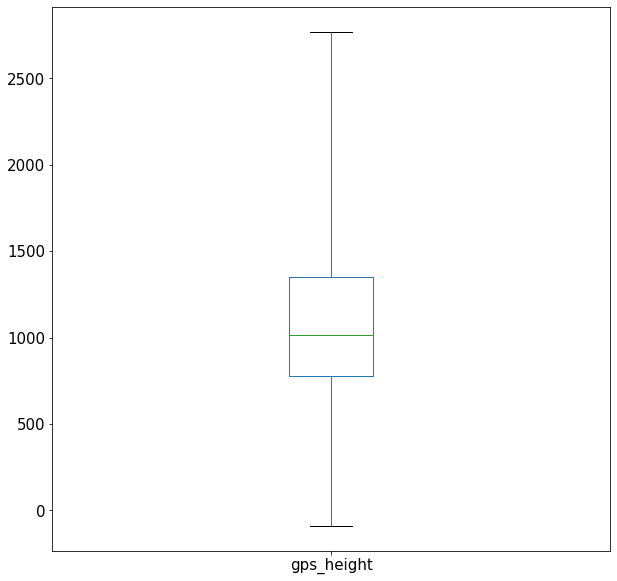

Analyzing outliers of column: longitude


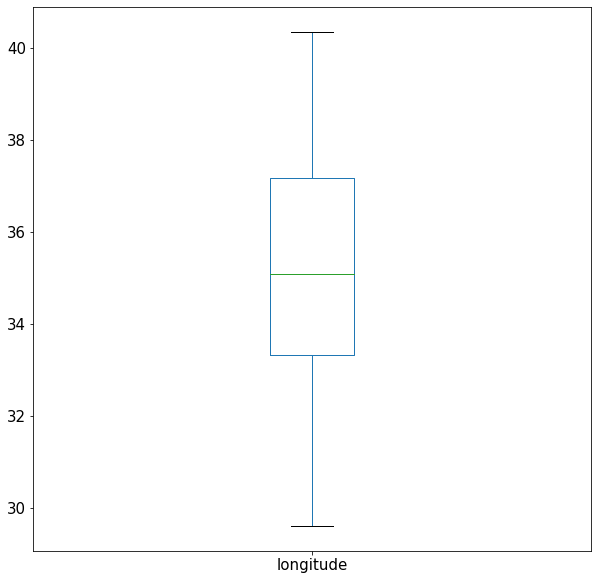

Analyzing outliers of column: population


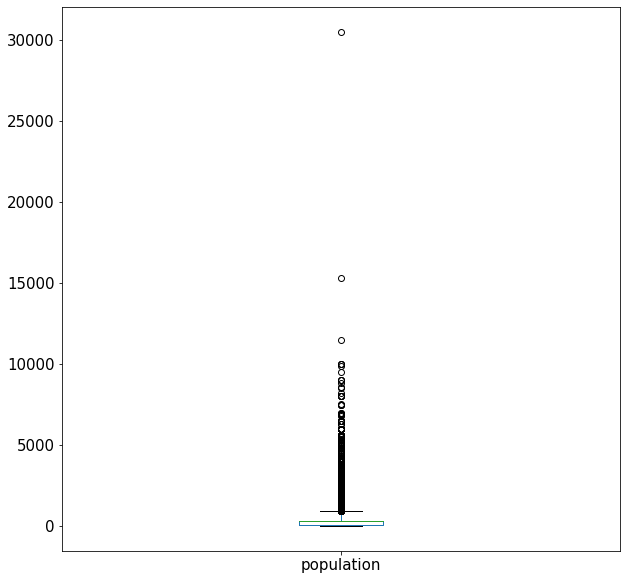

Analyzing outliers of column: construction_year


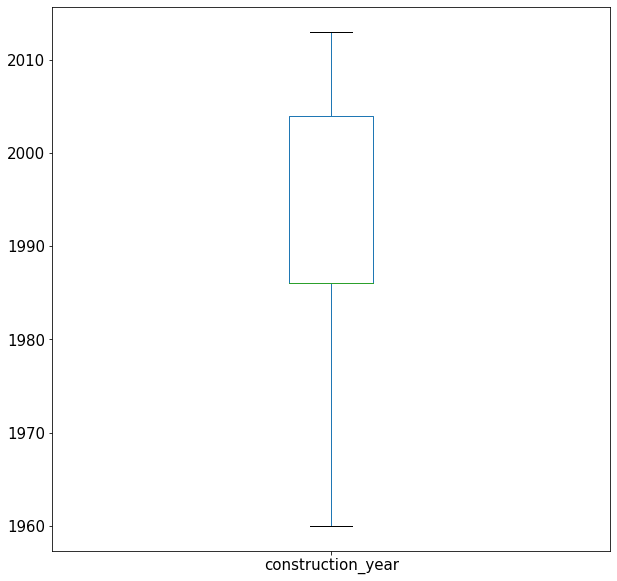

Analyzing outliers of column: lat_replaced_0s


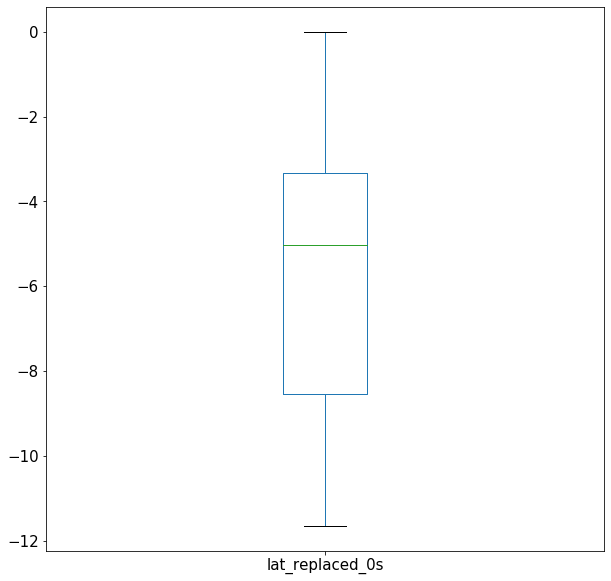

In [23]:
for (columnName, _) in outlier_free_dataset.iteritems():
    if columnName in ["longitude", "lat_replaced_0s", "gps_height", "population", "construction_year"]: #numeric columns
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        outlier_free_dataset.boxplot([columnName], grid=False, fontsize=15, whis=3)
        plt.show()

In [24]:
#impute fence high for outliers
q1 = outlier_free_dataset["population"].quantile(0.25)
q3 = outlier_free_dataset["population"].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr

print(fence_low)
print(fence_high) 

outlier_free_dataset["population"] = outlier_free_dataset["population"].map(lambda x:
                                                                           fence_low if x < fence_low else 
                                                                           (fence_high if x > fence_high else x))


-216.63289336385276
601.0548222730879


C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [25]:
# separate cleaned train set and test set
test_set_cleaned = dataset[dataset["train_or_test"] == "test"]
train_set_cleaned = outlier_free_dataset

In [26]:
#append cleaned train set and test set
cleaned_dataset = train_set_cleaned.append(test_set_cleaned)

Now that we have treated the numerical columns, we will clean the categorical columns further. Specifically, we noticed that columns `funder`, `installer` and `scheme_management` have a high number of unique values. If we keep them all in the dataset, the dummified dataset will contain too many columns and the model will be overfitted to the train data. Therefore, we will remove them. Upon first evaluation, we kept the top 4-5 categories for each of the variables, however we noticed that our accuracy increased as we added more categories. Perhaps there is meaningful information in these levels that we excluded in our first evaluation.

#### Reduce the categories  - `funder`, `installer` and `scheme_management`

In [27]:
#add the "Other" category to funder categories since it currently does not exist
cleaned_dataset['funder'] = cleaned_dataset['funder'].cat.add_categories('Other')

In [28]:
#Set values equal to "Other"
funder_categories = ["missing", "Government of Tanzania", "Danida", "Hesawa", "Rwssp", "World Bank", "Kkkt", "World Vision", "Unicef", "Tasaf", "Dhv", "District Council"]
    
cleaned_dataset.loc[~cleaned_dataset["funder"].isin(funder_categories), "funder"] = "Other"

In [29]:
#Check that it worked
cleaned_dataset["funder"].unique()

[Other, Unicef, Rwssp, Danida, World Vision, ..., District Council, Kkkt, Tasaf, World Bank, Dhv]
Length: 12
Categories (12, object): [Other, Unicef, Rwssp, Danida, ..., Kkkt, Tasaf, World Bank, Dhv]

In [30]:
#add the "Other" category to installer categories since it currently does not exist
cleaned_dataset['installer'] = cleaned_dataset['installer'].cat.add_categories('Other')

In [31]:
#Set values equal to "Other"
installer_categories = ["missing", "DWE", "Government", "RWE", "Commu", "DANIDA", "KKKT", "Hesawa", "0", "TCRS", "CES", "Central government", "DANID", "HESAWA"]
    
cleaned_dataset.loc[~cleaned_dataset["installer"].isin(installer_categories), "installer"] = "Other"

In [32]:
#Check that it worked
cleaned_dataset["installer"].unique()

[Other, DWE, DANIDA, missing, Central government, ..., CES, Hesawa, 0, DANID, TCRS]
Length: 15
Categories (15, object): [Other, DWE, DANIDA, missing, ..., Hesawa, 0, DANID, TCRS]

In [33]:
#Set values equal to "Other"
scheme_categories = ["missing", "VWC", "WUG", "Water Authority", "WUA", "Water Board", "Parastatal", "Company", "Private operator"]
    
cleaned_dataset.loc[~cleaned_dataset["scheme_management"].isin(scheme_categories), "scheme_management"] = "Other"

In [34]:
#Check that it worked
cleaned_dataset["scheme_management"].unique()

[VWC, Other, missing, Private operator, WUG, Water Board, WUA, Company, Parastatal]
Categories (9, object): [VWC, Other, missing, Private operator, ..., Water Board, WUA, Company, Parastatal]

Now that our dataset has a reduced number of values in the categorical columns, we can add some variables that we think can improve accuracy of our model

## Feature Creation

We created two variables that could be useful in indicating the functionality of a well. During our exploratory phase, we discovered that certain geographical locations in the `lga` variable are more likely to have wells that are functional compared to other locations. We created a variable called `lga_functionality` which assigns each `lga` as functional, functional needs repair nonfunctional, or unknown based on the highest percentage of these classes in the location. If there was no strong indication of a class, we left it as unknown. We also created a variable called `yrs_of_op`, which is the difference between the year the well was constructed and the year the well was recorded in the dataset. Using intuition, we can assume that the older the well, the more likely it is to be nonfunctional or needing repairs. The importance of these variables will be tested once we build a model and generate the variables importance graph.

In [35]:
#feature creation - years of operation

cleaned_dataset["recorded_year"] = cleaned_dataset["date_recorded"].dt.year

cleaned_dataset["yrs_of_op"] = (cleaned_dataset["recorded_year"] - cleaned_dataset["construction_year"])

In [36]:
df = cleaned_dataset.merge(train_labels, on='id')
df1 = df.groupby(['lga','status_group']).count()

dic_func = {}

for row in df1['id'].groupby(level=0):
    try:
        functional = row[1].xs('functional', level=1)[0]
    except KeyError:
        functional = 0
    try:
        functional_repair = row[1].xs('functional needs repair', level=1)[0]
    except KeyError:
        functional_repair = 0
    try:
        nonfunctional = row[1].xs('non functional', level=1)[0]
    except KeyError:
        nonfunctional = 0
    
    total = functional + nonfunctional + functional_repair
    
    functional = (functional/total) * 100
    functional_repair = (functional_repair/total) * 100
    nonfunctional = (nonfunctional/total) * 100
    
    status = [functional,functional_repair,nonfunctional]
    status.sort(reverse = True)
    
    if status[0] > status[1] * 1.3:
        if status[0] == functional:
            dic_func[row[0]] = 'functional'
        elif status[0] == functional_repair:
            dic_func[row[0]] = 'functional needs repair'
        else:
            dic_func[row[0]] = 'non functional'
    else:
        dic_func[row[0]] = 'unknown'

In [37]:
cleaned_dataset['lga_functionality'] = cleaned_dataset['lga'].map(lambda x: dic_func[x])
cleaned_dataset[['lga_functionality','lga']]

,lga_functionality,lga
0,functional,Ludewa
1,functional,Serengeti
2,functional,Simanjiro
3,non functional,Nanyumbu
4,unknown,Karagwe
...,...,...
14845,functional,Bagamoyo
14846,unknown,Kilindi
14847,unknown,Singida Rural
14848,functional,Songea Rural


In [38]:
cleaned_dataset.drop(["lga"], axis=1, inplace=True)

In [39]:
cleaned_dataset["lga_functionality"] = cleaned_dataset["lga_functionality"].astype("category")

Now that we are satisfied with the data type and information of every variable in our dataset, we can dummify the dataset for modeling.

## Dummify the dataset

In [40]:
cleaned_dataset.dtypes

id                                int64
date_recorded            datetime64[ns]
funder                         category
gps_height                      float64
installer                      category
longitude                       float64
basin                          category
region                         category
population                      float64
scheme_management              category
permit                         category
construction_year                 int64
extraction_type_class          category
management                     category
payment_type                   category
water_quality                  category
quantity                       category
source                         category
waterpoint_type_group          category
train_or_test                    object
lat_replaced_0s                 float64
recorded_year                     int64
yrs_of_op                         int64
lga_functionality              category
dtype: object

In [41]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = cleaned_dataset.columns[cleaned_dataset.dtypes=='category'].tolist()
numerical_cols = cleaned_dataset.columns[cleaned_dataset.dtypes!='category'].tolist()

numerical_cols.remove("id")
numerical_cols.remove("date_recorded")
numerical_cols.remove("train_or_test")
numerical_cols.remove("construction_year")

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

In [42]:
#make sure all values in the categorical columns are strings, so that OHE will work
for i in categorical_cols:
    cleaned_dataset[i] = cleaned_dataset[i].astype(str)

In [43]:
#convert back into category so that OHE will work
for i in categorical_cols:
    cleaned_dataset[i] = cleaned_dataset[i].astype("category")

In [44]:
#ensure all values in numerical columns are indeed numerical, so that normalizing will work
for i in numerical_cols:
    cleaned_dataset[i] = cleaned_dataset[i].astype(int)

In [45]:
dummified_dataset = pd.concat([cleaned_dataset['id'].reset_index(drop=True),
                               cleaned_dataset['train_or_test'].reset_index(drop=True),
                              cleaned_dataset['date_recorded'].reset_index(drop=True),
                               cleaned_dataset['construction_year'].reset_index(drop=True),
                               pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(cleaned_dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(cleaned_dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)], sort=True, axis=1)

In [46]:
dummified_dataset.head()

,id,train_or_test,date_recorded,construction_year,gps_height,longitude,population,lat_replaced_0s,recorded_year,yrs_of_op,funder_Danida,funder_Dhv,funder_District Council,funder_Hesawa,funder_Kkkt,funder_Other,funder_Rwssp,funder_Tasaf,funder_Unicef,funder_World Bank,...,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,lga_functionality_functional,lga_functionality_non functional,lga_functionality_unknown
0,69572,train,2011-03-14,1999,0.516219,0.454545,0.009418,0.181818,0.833333,0.316667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,8776,train,2013-03-06,2010,0.519358,0.454545,0.024329,0.818182,1.000000,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,34310,train,2013-02-25,2009,0.270666,0.727273,0.021713,0.727273,1.000000,0.183333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,67743,train,2013-01-28,1986,0.123125,0.818182,0.004970,0.000000,1.000000,0.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,19728,train,2011-07-13,1986,0.385769,0.181818,0.025549,0.909091,0.833333,0.533333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
#convert floats to ints
dummified_dataset = dummified_dataset.iloc[:, :6].join(dummified_dataset.iloc[:, 6:].astype(int), sort=True)

In [48]:
dummified_dataset.head()

,id,train_or_test,date_recorded,construction_year,gps_height,longitude,population,lat_replaced_0s,recorded_year,yrs_of_op,funder_Danida,funder_Dhv,funder_District Council,funder_Hesawa,funder_Kkkt,funder_Other,funder_Rwssp,funder_Tasaf,funder_Unicef,funder_World Bank,...,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,lga_functionality_functional,lga_functionality_non functional,lga_functionality_unknown
0,69572,train,2011-03-14,1999,0.516219,0.454545,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,8776,train,2013-03-06,2010,0.519358,0.454545,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
2,34310,train,2013-02-25,2009,0.270666,0.727273,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,67743,train,2013-01-28,1986,0.123125,0.818182,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,19728,train,2011-07-13,1986,0.385769,0.181818,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [49]:
#split the dataset into train and test
train_cleaned = dummified_dataset[dummified_dataset['train_or_test'] == "train"]
test_cleaned = dummified_dataset[dummified_dataset['train_or_test'] == "test"]

In [50]:
#add the labels to the train set
train_cleaned = train_cleaned.merge(train_labels, on="id")

In [51]:
train_cleaned = train_cleaned.drop(['train_or_test'],axis=1)

In [52]:
train_cleaned.head()

,id,date_recorded,construction_year,gps_height,longitude,population,lat_replaced_0s,recorded_year,yrs_of_op,funder_Danida,funder_Dhv,funder_District Council,funder_Hesawa,funder_Kkkt,funder_Other,funder_Rwssp,funder_Tasaf,funder_Unicef,funder_World Bank,funder_World Vision,...,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,lga_functionality_functional,lga_functionality_non functional,lga_functionality_unknown,status_group
0,69572,2011-03-14,1999,0.516219,0.454545,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,functional
1,8776,2013-03-06,2010,0.519358,0.454545,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,functional
2,34310,2013-02-25,2009,0.270666,0.727273,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,functional
3,67743,2013-01-28,1986,0.123125,0.818182,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,non functional
4,19728,2011-07-13,1986,0.385769,0.181818,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,functional


In [53]:
X_train = train_cleaned.loc[:, train_cleaned.columns != 'status_group']
y_train = train_cleaned['status_group']
X_train.to_csv("X_train.csv")

In [54]:
X_train = X_train.drop(['date_recorded', 'id'],axis=1)
test_cleaned = test_cleaned.drop(['date_recorded', 'id', 'train_or_test'],axis=1)

## Model Training

In this phase of the machine learning pipeline, we explored a few different types of models, including logistic regression, XGBoost and random forest. Logistic regression proved to be the most unreliable model, most probably because it is not equipped to handle a large amount of features. XGBoost was better in accuracy compared to logistic regression, however random forest consistently delivered the best results. Random forest modelling will be shown below. 

### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

#start with the basic hyperparameters to get a baseline model
rfc_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                                  max_features = 'sqrt')

rfc_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Training Accuracy = 0.7758


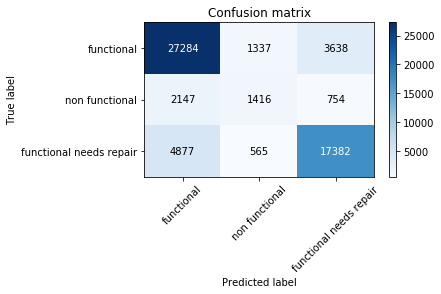

In [56]:
rfc_fitted_model, score = train_model(X_train, y_train, rfc_model)

We had to play around with the number of features to include in the final model. By reducing our variables to only the most important ones, we simplify the model and avoid overfitting when fitting the model to test data. Limiting the number of variables also speeds the process of RandomSearch which is used below to find the optimal hyperparameters for our model.

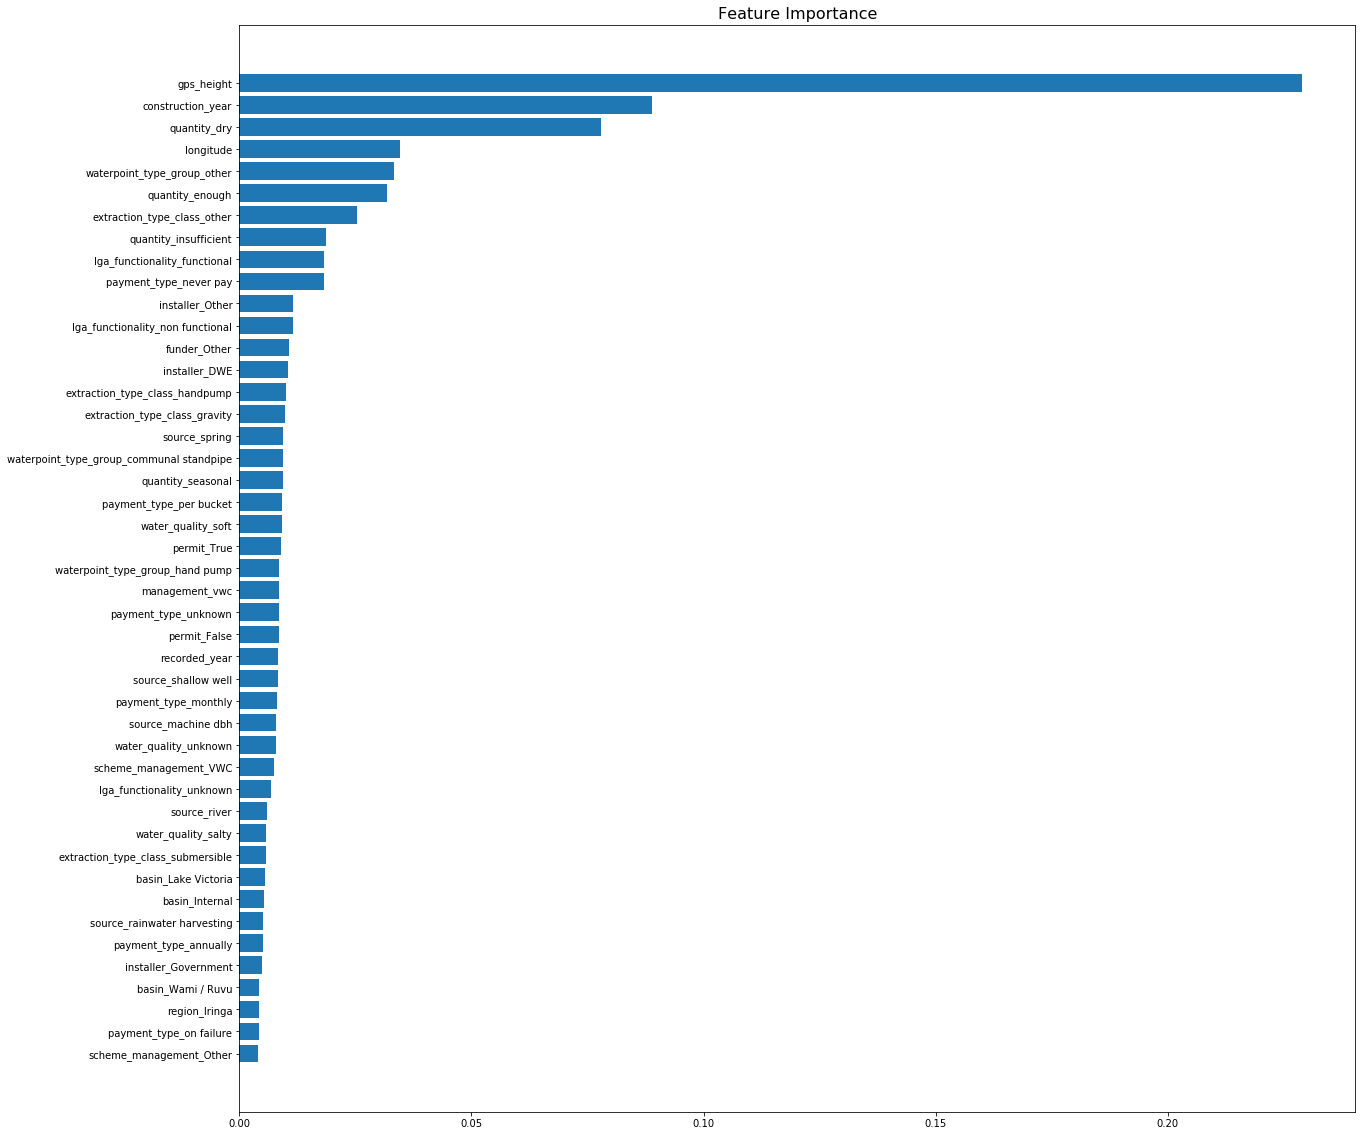

In [57]:
sorted_idx = np.argsort(rfc_fitted_model.feature_importances_)[::-1][:45][::-1]

plt.figure(figsize=(20,20))
plt.barh(X_train.columns[sorted_idx], rfc_fitted_model.feature_importances_[sorted_idx], align='center')
plt.title('Feature Importance', fontsize=16)
plt.show()

In [58]:
rfc_imp_vars = list(X_train.columns[sorted_idx])

When using our baseline model with the top features, our training accuracy usually decreased. We learned that the best way to utilize the most important features is by combining it with random search, which finds the best hyperparameters for our sliced dataset (only includes most important variables).

In [59]:
# rfc_fitted_model2, score = train_model(X_train[rfc_imp_vars], y_train, rfc_model)

#### RF Model 3 - Random Search with Feature Importance Slicing

In [60]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [61]:
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train[rfc_imp_vars], y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 64.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [62]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [72]:
rfc_model2 = RandomForestClassifier(n_estimators=1200, bootstrap = True, max_features = 'auto', min_samples_split = 2, min_samples_leaf = 2)

In [73]:
rfc_model2.fit(X_train[rfc_imp_vars], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Training Accuracy = 0.7956


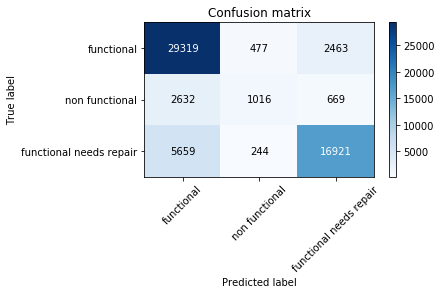

In [74]:
rfc_fitted_model_2, score = train_model(X_train[rfc_imp_vars], y_train, rfc_model2)

# Test the model

In [77]:
X_test = test_cleaned[rfc_imp_vars]

In [80]:
# Train the model using all the data
final_model = rfc_model2
final_model.fit(X_train[rfc_imp_vars], y_train)

# Test prediction
final_pred = final_model.predict(X_test)
predictions = pd.DataFrame({'id':test['id'], 'status_group':final_pred})
predictions.to_csv("well_predictions10.csv", index=False)

## Feature Engineering

Besides the variable importance generated above, we also tried Chi Squared test and Information Gain to determine the most important variables. We realized that the variable importance provided by the random forest model above were most successful in building an accurate model. This is probably due the the fact that the random forest algorithm learned the data better than Chi Squared and Information Gain, which are simpler math calculations used for simpler datasets. 

##### Chi Squared

In [68]:
# from sklearn.feature_selection import SelectKBest, chi2
# from operator import itemgetter

# chi2_selector = SelectKBest(score_func=chi2).fit(X_train, y_train)

# # Get the indices sorted by most important to least important
# indices = np.argsort(chi2_selector.scores_)[::-1]

# chi2_features = defaultdict(float)
# for i in range(len(X_train.columns)):
#     chi2_features[(X_train).columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
# items = sorted(chi2_features.items(), key=itemgetter(1), reverse=True)
# keys, values = list(zip(*items))

# plt.figure(figsize=(10,10))
# plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
# plt.barh(list(range(len(keys))), values, color='r', align='center')
# chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25)
# plt.axvline(chi2_th, color='blue')
# plt.gca().invert_yaxis()

# plt.show()

# print("ChiSquared Threshold", chi2_th)

In [69]:
# chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()
# chi2_model, score = train_model(X_train.drop(list(chi2_features_to_remove), axis=1), y_train, rfc_model)

##### Information Gain

In [70]:
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.feature_selection import SelectKBest

# ig_selector = SelectKBest(score_func=mutual_info_classif).fit(X_train, y_train)


# # Get the indices sorted by most important to least important
# indices = np.argsort(ig_selector.scores_)[::-1]

# ig_features = defaultdict(float)
# for i in range(len(X_train.columns)):
#     ig_features[X_train.columns[indices[i]]] += ig_selector.scores_[indices[i]]
    
# items = sorted(ig_features.items(), key=itemgetter(1), reverse=True)
# keys, values = list(zip(*items))

# # Now plot
# plt.figure(figsize=(10,10))
# plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
# plt.barh(list(range(len(keys))), values, color='r', align='center')
# ig_th = 0.01
# plt.axvline(ig_th, color='blue')
# plt.gca().invert_yaxis()

# plt.show()

# print("IG Threshold", ig_th)

In [71]:
# ig_features_to_remove = dict(filter(lambda x: x[1] <= ig_th, ig_features.items())).keys()
# print("Features to remove = {}".format(ig_features_to_remove))
# ig_model, score = train_model(X_train.drop(list(ig_features_to_remove), axis=1), y_train, rfc_model)

## Conclusion

The most important and time consuming phase of this challenge was the data cleaning and preparation phase. Whenever we wanted to improve our model, we had to revisit this phase in order to extract different infromation, or reduce information, for each run. With each tweak in the data cleaning section, we learned what was most useful for our model. More information (i.e. keeping all outliers in the dataset) and more accurate information (i.e. using subvillage to extract a truer mean for population) were key findings that guided our decisions throughout the challenge and ultimately resulted in an accurate and reliable model.